In [9]:
import os
import sys
import random
import warnings
import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
TRAIN_PATH_=r'C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/정맥추출_전체(152X60)/' 
TRAIN_PATH=r'C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/input_train/'
TEST_PATH =r'C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/input_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

## Train, Test

In [40]:
# #한글이름 사진 로드

# #gray로 불러와야 threshold  함수 사용가능
# def hangulFilePathImageRead2 (filePath ) :  
#     stream = open( filePath.encode("utf-8") , "rb")
#     bytes = bytearray(stream.read())
#     numpyArray = np.asarray(bytes, dtype=np.uint8)

#     return cv2.imdecode(numpyArray , cv2.IMREAD_GRAYSCALE)

# def hangulFilePathImageRead (filePath ) :

#     stream = open( filePath.encode("utf-8") , "rb")
#     bytes = bytearray(stream.read())
#     numpyArray = np.asarray(bytes, dtype=np.uint8)

#     return cv2.imdecode(numpyArray , cv2.IMREAD_COLOR)  #3채널로 가져오기

# #train
# if __name__ == '__main__':
#     train_mask_=[]
#     train__=[]
#     for f in os.listdir(TRAIN_PATH):  
#         if f.split('.')[1] =='jpg':
#             filePath = (r"C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/input_train"+'/'+f)  
#             train_= hangulFilePathImageRead2(filePath)  #이미지
#             train__.append(train_)
#             train_mask = cv2.adaptiveThreshold(train_,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,19, 15) #마스크
#             train_mask_.append(train_mask)
            
            
            
# #test
# if __name__ == '__main__':
#     test_mask_=[]
#     test__=[]
#     for f_ in os.listdir(TEST_PATH):  
#         if f_.split('.')[1] =='jpg':
#             filePath = (r"C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/input_test"+'/'+f_)  
#             test_ = hangulFilePathImageRead2(filePath)  #이미지
#             test__.append(test_)
#             test_mask = cv2.adaptiveThreshold(test_,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,19, 15)  #마스크
#             test_mask_.append(test_mask)
            
# #             print(f_)

In [11]:
# Get train and test IDs
train_path=os.walk(TRAIN_PATH)  #agumenatation한것_에러 안남
train_ids = next(train_path)[2]

train_path_=os.walk(TRAIN_PATH_) #추출한것
train_ids_ = next(train_path_)[2]

test_path=os.walk(TEST_PATH)
test_ids = next(test_path)[2]

In [12]:
a=np.array(train_ids)
a.shape

(2992,)

In [13]:
train_ids

['[SEG]이지우_1_1_0_1148.jpg',
 '[SEG]이지우_1_1_0_1283.jpg',
 '[SEG]이지우_1_1_0_1360.jpg',
 '[SEG]이지우_1_1_0_1525.jpg',
 '[SEG]이지우_1_1_0_1732.jpg',
 '[SEG]이지우_1_1_0_1734.jpg',
 '[SEG]이지우_1_1_0_1750.jpg',
 '[SEG]이지우_1_1_0_1765.jpg',
 '[SEG]이지우_1_1_0_1768.jpg',
 '[SEG]이지우_1_1_0_1948.jpg',
 '[SEG]이지우_1_1_0_2015.jpg',
 '[SEG]이지우_1_1_0_2037.jpg',
 '[SEG]이지우_1_1_0_2197.jpg',
 '[SEG]이지우_1_1_0_2281.jpg',
 '[SEG]이지우_1_1_0_2330.jpg',
 '[SEG]이지우_1_1_0_2388.jpg',
 '[SEG]이지우_1_1_0_2487.jpg',
 '[SEG]이지우_1_1_0_2785.jpg',
 '[SEG]이지우_1_1_0_2916.jpg',
 '[SEG]이지우_1_1_0_3006.jpg',
 '[SEG]이지우_1_1_0_3020.jpg',
 '[SEG]이지우_1_1_0_3053.jpg',
 '[SEG]이지우_1_1_0_3075.jpg',
 '[SEG]이지우_1_1_0_310.jpg',
 '[SEG]이지우_1_1_0_313.jpg',
 '[SEG]이지우_1_1_0_3314.jpg',
 '[SEG]이지우_1_1_0_3375.jpg',
 '[SEG]이지우_1_1_0_348.jpg',
 '[SEG]이지우_1_1_0_3717.jpg',
 '[SEG]이지우_1_1_0_3796.jpg',
 '[SEG]이지우_1_1_0_3800.jpg',
 '[SEG]이지우_1_1_0_3873.jpg',
 '[SEG]이지우_1_1_0_3904.jpg',
 '[SEG]이지우_1_1_0_3924.jpg',
 '[SEG]이지우_1_1_0_3996.jpg',
 '[SEG]이지우_1_1_0_4037.j

## 추출된 이미지
이진화 한 것을 mask에 저장

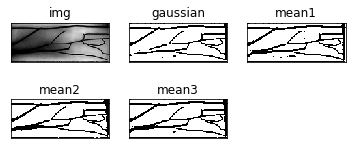

In [46]:
# import cv2
# import numpy as np 
# from matplotlib import pyplot as plt 
# img=hangulFilePathImageRead2('C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/정맥추출_전체(152X60)/[SEG]조황원_3_1.jpg')

# ret, th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# gaussian = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
# cv2.THRESH_BINARY,15,8)

# mean1 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,11, 7)

# mean2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,19, 15)

# mean3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,15, 11)

# titles = ['img','gaussian','mean1','mean2','mean3']

# images = [img,gaussian,mean1,mean2,mean3]

# for i in range(5):
# 	plt.subplot(3,3,i+1),plt.imshow(images[i],'gray')
# 	plt.title(titles[i])
# 	plt.xticks([]),plt.yticks([])

# plt.show()

In [ ]:
# mean2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,19, 15)

In [5]:
a = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
a.shape # (3,4)
a.ndim # 2


2

In [6]:
b = np.array([[1,2,3,4], [5,6,7,8], [9,10,11]])
b.shape # (3,)
b.ndim # 1

1

## 데이터 전처리

에러안남

In [17]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
#     path = TRAIN_PATH + id_
    img = imread(TRAIN_PATH+id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask=cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,19, 15) #마스크
    Y_train[n] = mask
#     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         mask_ = imread(path + '/masks/' + mask_file)
#         mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)
#         mask = np.maximum(mask, mask_)
#     Y_train[n] = mask

# # Get and resize test images
# X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# sizes_test = []
# print('Getting and resizing test images ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#     path = TEST_PATH + id_
#     img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     sizes_test.append([img.shape[0], img.shape[1]])
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_test[n] = img

# print('Done!')

Getting and resizing train images and masks ... 


  0%|                                                                                         | 0/2992 [00:00<?, ?it/s]


error: OpenCV(3.4.2) C:\projects\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1524: error: (-215:Assertion failed) src.type() == (((0) & ((1 << 3) - 1)) + (((1)-1) << 3)) in function 'cv::adaptiveThreshold'


In [18]:
img.shape

(128, 128, 1)

에러남

In [14]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): #tqdm:진행바 표시
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask=cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,19, 15) #마스크
    Y_train[n] = mask
    

    
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         mask_ = imread(path + '/masks/' + mask_file)
#         mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)
#     mask = np.maximum(mask, mask_)
    mask=cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,19, 15) #마스크
    Y_train[n] = mask

# # Get and resize test images
# X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# sizes_test = []
# print('Getting and resizing test images ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#     path='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/input_test/'
#     img = imread(path+f_)[:,:,:IMG_CHANNELS]
#     sizes_test.append([img.shape[0], img.shape[1]])
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_test[n] = img

# print('Done!')

Getting and resizing train images and masks ... 


  0%|                                                                                         | 0/2992 [00:00<?, ?it/s]


NameError: name 'path' is not defined

In [33]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

NameError: name 'X_train' is not defined

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [8]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

In [9]:
s.shape

TensorShape([Dimension(None), Dimension(128), Dimension(128), Dimension(3)])

In [10]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)
print(s)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
print("c1",c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
print("c1",c1)
p1 = MaxPooling2D((2, 2)) (c1)
print("p1",p1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
print("c2",c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
print("c2",c2)
p2 = MaxPooling2D((2, 2)) (c2)
print("p2",p2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
print("c3",c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
print("c3",c3)
p3 = MaxPooling2D((2, 2)) (c3)
print("p3",p3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
print("c4",c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
print("c4",c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
print("p4",p4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Tensor("lambda_2/truediv:0", shape=(?, 128, 128, 3), dtype=float32)
c1 Tensor("conv2d_1/Elu:0", shape=(?, 128, 128, 16), dtype=float32)
c1 Tensor("conv2d_2/Elu:0", shape=(?, 128, 128, 16), dtype=float32)

p1 Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 64, 64, 16), dtype=float32)
c2 Tensor("conv2d_3/Elu:0", shape=(?, 64, 64, 32), dtype=float32)
c2 Tensor("conv2d_4/Elu:0", shape=(?, 64, 64, 32), dtype=float32)
p2 Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 32, 32, 32), dtype=float32)
c3 Tensor("conv2d_5/Elu:0", shape=(?, 32, 32, 64), dtype=float32)
c3 Tensor("conv2d_6/Elu:0", shape=(?, 32, 32, 64), dtype=float32)
p3 Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 16, 16, 64), dtype=float32)
c4 Tensor("conv2d_7/Elu:0", shape=(?, 16, 16, 128), dtype=float32)
c4 Tensor("conv2d_8/Elu:0", shape=(?, 16, 16, 128), dtype=float32)
p4 Tensor("max_pooling2d_4/MaxPool:0", shape=(?, 8, 8, 128), dtype=float32)
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where 

In [13]:
train_.shape

(60, 152)

In [14]:
train_mask.shape

(60, 152)

In [18]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(a, b, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

ValueError: Error when checking input: expected input_2 to have 4 dimensions, but got array with shape (3008, 60, 152)

In [ ]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)